In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importer la base de données
db =pd.read_csv('DonnesNetatmo27avril.csv', sep=";" )
#db=db.stack().str.replace(',','.').unstack()
db1=db


db=db.drop(['time'],axis=1)
#db_date=db['Date/Heure']
#db1=db.iloc[1:]

db.iloc[:,:] = db.iloc[:,:].astype(float)
db['time']=pd.to_datetime(db1['time'], infer_datetime_format=True)
df=db

In [3]:
df.head()

,temperature,co2,humidity,noise,Pressure,time
0,23.5,735.0,53.0,34.0,1021.6,2021-03-25 19:22:30
1,20.0,654.0,61.0,33.0,1021.6,2021-03-25 19:27:30
2,19.5,654.0,62.0,33.0,1021.5,2021-03-25 19:32:30
3,19.4,629.0,62.0,33.0,1021.4,2021-03-25 19:37:30
4,19.4,609.0,62.0,32.0,1021.5,2021-03-25 19:42:30


<AxesSubplot:>

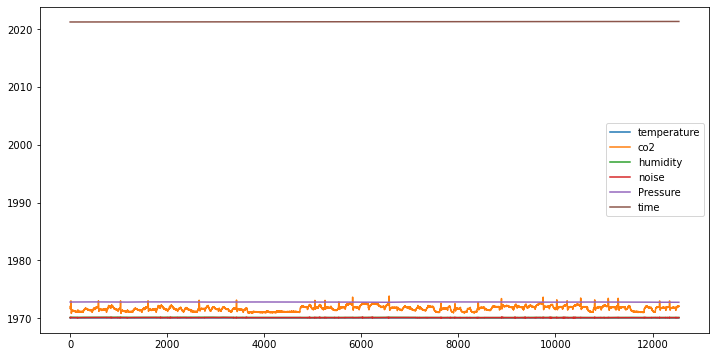

In [4]:
df.plot(figsize=(12,6))

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
results = seasonal_decompose(df['co2'])
results.plot();

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [8]:
len(df)

12544

In [9]:
train = df.iloc[:156]
test = df.iloc[156:]

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [11]:
df.head(),df.tail()

(   temperature    co2  humidity  noise  Pressure                time
 0         23.5  735.0      53.0   34.0    1021.6 2021-03-25 19:22:30
 1         20.0  654.0      61.0   33.0    1021.6 2021-03-25 19:27:30
 2         19.5  654.0      62.0   33.0    1021.5 2021-03-25 19:32:30
 3         19.4  629.0      62.0   33.0    1021.4 2021-03-25 19:37:30
 4         19.4  609.0      62.0   32.0    1021.5 2021-03-25 19:42:30,
        temperature    co2  humidity  noise  Pressure                time
 12539         19.1  749.0      42.0   42.0    1006.3 2021-04-27 13:38:20
 12540         19.1  735.0      43.0   43.0    1006.2 2021-04-27 13:43:20
 12541         19.2  757.0      45.0   43.0    1006.2 2021-04-27 13:48:20
 12542         19.2  761.0      46.0   40.0    1006.1 2021-04-27 13:53:20
 12543         19.2  772.0      45.0   41.0    1006.1 2021-04-27 13:58:20)

In [12]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

TypeError: invalid type promotion

In [13]:
scaled_train[:10]

NameError: name 'scaled_train' is not defined

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

NameError: name 'scaled_train' is not defined

In [16]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

NameError: name 'generator' is not defined

In [17]:
X.shape

(1, 3, 1)

In [18]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [19]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [20]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 15s 3ms/step - loss: 0.0984
Epoch 2/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 5/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0084
Epoch 6/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0043
Epoch 7/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0029
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 9/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 10/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0040
Epoch 11/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 12/50
144/144 [==============================] - 0s 3ms/step - loss: 0.0041
Epoch 13/50
144/144 [===

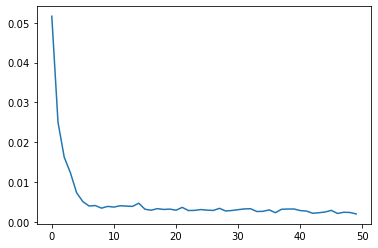

In [23]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [24]:
last_train_batch = scaled_train[-12:]

In [25]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [26]:
model.predict(last_train_batch)

array([[0.6031264]], dtype=float32)

In [27]:
scaled_test[0]

array([0.67548077])

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [29]:
test_predictions

[array([0.6031264], dtype=float32),
 array([0.6034701], dtype=float32),
 array([0.75184035], dtype=float32),
 array([0.8237616], dtype=float32),
 array([0.9035673], dtype=float32),
 array([0.8911582], dtype=float32),
 array([0.83372116], dtype=float32),
 array([0.74567354], dtype=float32),
 array([0.6453606], dtype=float32),
 array([0.5967568], dtype=float32),
 array([0.55612695], dtype=float32),
 array([0.5788646], dtype=float32)]

In [30]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

<ipython-input-32-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<AxesSubplot:xlabel='Date'>

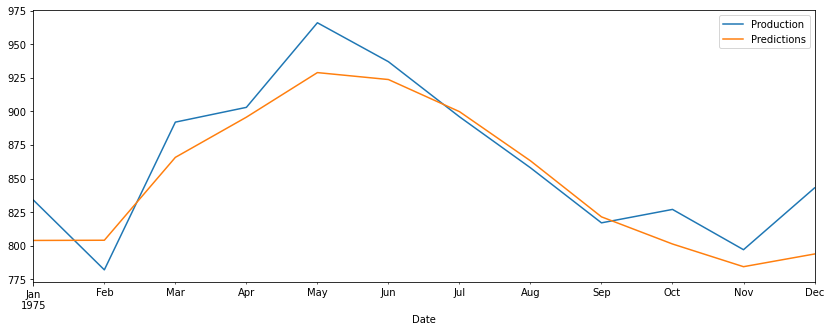

In [33]:
test.plot(figsize=(14,5))

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

24.138819628970005
